In [20]:
import legume
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
def calculate_n2(x, y, wavelength_um = 1.55):
    """
    Calculates n^2 for given composition (x, y) and wavelength (µm).
    Handles negative R values safely.
    """
    # Convert wavelength (µm) to photon energy (eV)
    E = 1.23984193 / wavelength_um  # hc = 1.23984193 eV·µm

    # Bandgap energy Eg (in eV)
    Eg = (1.35 + 0.668*x - 1.068*y + 0.758*x**2 + 0.078*y**2 - 0.069*x*y - 0.332*x**2*y + 0.03*x*y**2)
    # Material-dependent coefficients
    R = -0.00115 + 0.00191 * Eg
    Gamma = -0.000691 + 0.00433 * Eg
    A = -0.0453 + 2.1103 * Eg
    a = 72.32 + 12.78 * Eg
    b = 4.84 + 4.66 * Eg
    c = -0.015 + 0.02 * Eg
    d = -0.178 + 1.042 * Eg

    # Complex photon energy
    E_complex = E + 1j * Gamma

    # Complex-safe sqrt
    sqrtR = np.sqrt(R + 0j)

    # Define cotangent for complex arguments
    cot = lambda z: 1 / np.tan(z)

    # n^2 - 1 formula
    term1 = a / (b - E_complex**2)
    term2_factor = A * sqrtR / (E_complex**2)

    log_term = np.log(Eg**2 / (Eg**2 - E_complex**2))
    cot_term1 = 2 * cot(np.pi * np.sqrt((R / Eg) + 0j))
    cot_term2 = cot(np.pi * np.sqrt((R / (Eg - E_complex)) + 0j))
    cot_term3 = cot(np.pi * np.sqrt((R / (Eg + E_complex)) + 0j))

    bracket_term = log_term + np.pi * (cot_term1 - cot_term2 - cot_term3)
    term2 = term2_factor * bracket_term

    n2_minus_1 = term1 + term2
    n2 = 1 + n2_minus_1

    return n2.real  # Return the real part (physical refractive index squared)

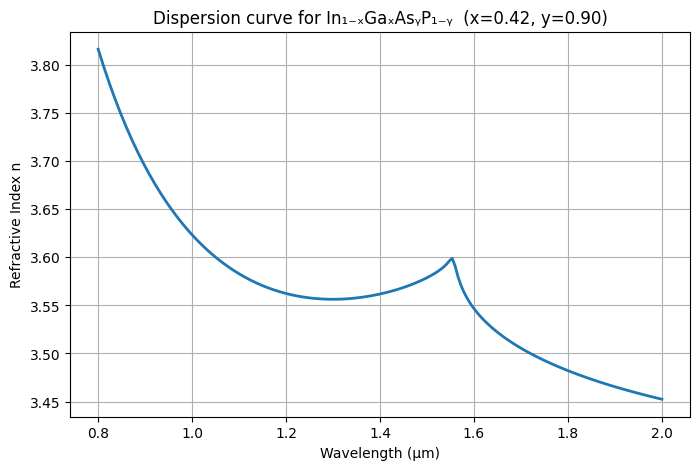

In [13]:
def plot_n_vs_lambda(x, y, lambda_min=0.8, lambda_max=2.0, num_points=200):
    """
    Plots refractive index n as a function of wavelength for given x, y.
    """
    wavelengths = np.linspace(lambda_min, lambda_max, num_points)
    n_values = []

    for wl in wavelengths:
        n2_val = calculate_n2(x, y, wl)
        n_val = np.sqrt(n2_val) if n2_val > 0 else np.nan
        n_values.append(n_val)

    plt.figure(figsize=(8, 5))
    plt.plot(wavelengths, n_values, lw=2)
    plt.xlabel("Wavelength (µm)")
    plt.ylabel("Refractive Index n")
    plt.title(f"Dispersion curve for In₁₋ₓGaₓAsᵧP₁₋ᵧ  (x={x:.2f}, y={y:.2f})")
    plt.grid(True)
    plt.show()


# Example usage:
plot_n_vs_lambda(x=0.42, y=0.90) 

In [22]:
D_cap = 10e-3
D_well = 10e-3
D_barrier = 20e-3
fac = 1
r_holes = 120e-3 * fac
a = 500e-3 * fac

x_barrier = 0.56
y_barrier = 0.938
x_well = 0.734
y_well =  0.57
n_InP = 3.1538

eps_cap = (n_InP)**2
eps_well = calculate_n2(1-x_well, y_well)
eps_barrier = calculate_n2(1-x_barrier, y_barrier)
eps_holes = 1.0

theta = np.deg2rad(6.01)  
# Reciprocal lattice vectors of layer 1
G11 = (2*np.pi/(np.sqrt(3)*a)) * np.array([np.sqrt(3), 1])
G12 = (2*np.pi/(np.sqrt(3)*a)) * np.array([np.sqrt(3), -1])

# Rotate to get reciprocal lattice vectors of layer 2
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
G21 = R @ G11
G22 = R @ G12

# Moiré reciprocal vectors (difference)
g1_moire = G11 - G21
g2_moire = G12 - G22


G_moire = np.column_stack([g1_moire, g2_moire])
A_moire = 2*np.pi * np.linalg.inv(G_moire.T) 

A1 = A_moire[:,0]
A2 = A_moire[:,1]

df = pd.read_csv("moire_points.csv")
x = np.array(df.x_cent)
y = np.array(df.y_cent)

lattice = legume.Lattice(A1, A2)
phc = legume.PhotCryst(lattice, eps_l=1., eps_u=1.)

for i in range(6):
    phc.add_layer(d=D_barrier, eps_b=eps_barrier)
    for i in range(len(x)):
        circle = legume.Circle(eps=eps_holes, x_cent=x[i], y_cent=y[i], r=r_holes)
        phc.add_shape(circle)
    phc.add_layer(d=D_well, eps_b=eps_well)
    for i in range(len(x)):
        circle = legume.Circle(eps=eps_holes, x_cent=x[i], y_cent=y[i], r=r_holes)
        phc.add_shape(circle)
phc.add_layer(d=D_barrier, eps_b=eps_barrier)
for i in range(len(x)):
    circle = legume.Circle(eps=eps_holes, x_cent=x[i], y_cent=y[i], r=r_holes)
    phc.add_shape(circle)

# phc.add_layer(d=D_cap, eps_b=eps_cap)
# for i in range(len(x)):
#     circle = legume.Circle(eps=eps_holes, x_cent=x[i], y_cent=y[i], r=r_holes)
#     phc.add_shape(circle)
# N_Res = 100
# legume.viz.structure(phc, yz=True, figsize=10., Nx = N_Res, Ny = N_Res, cbar=False)

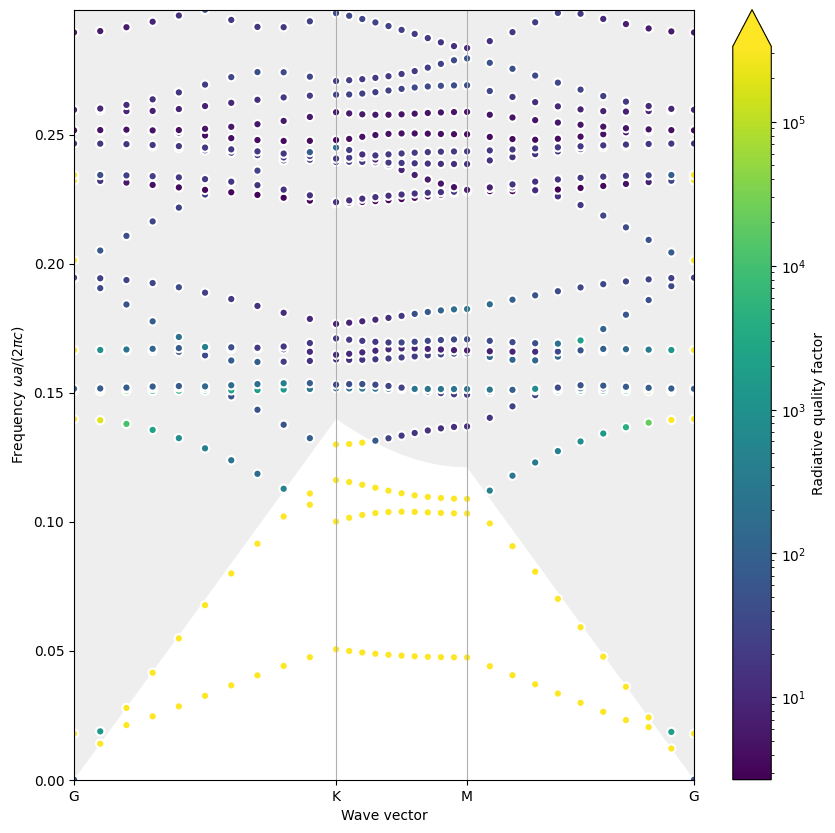

In [24]:
gme = legume.GuidedModeExp(phc, gmax=7)
Gamma = [0,0]
K = (g1_moire + g2_moire)/3
M = g1_moire/2
k_points = [Gamma, K, M, Gamma]
N_points = 10
path = lattice.bz_path(k_points, [N_points,N_points,N_points])
path['labels'] = ['G', 'K', 'M', 'G']
gme.run(kpoints=path['kpoints'],
        gmode_inds=[0, 3],
        numeig=20,
        verbose=False)
fig, ax = plt.subplots(1, figsize = (10, 10))
legume.viz.bands(gme, figsize=(10,10), k_units=True, Q=True, ax=ax)
ax.set_xticks(path['k_indexes'])
ax.set_xticklabels(path['labels'])
ax.xaxis.grid('True')

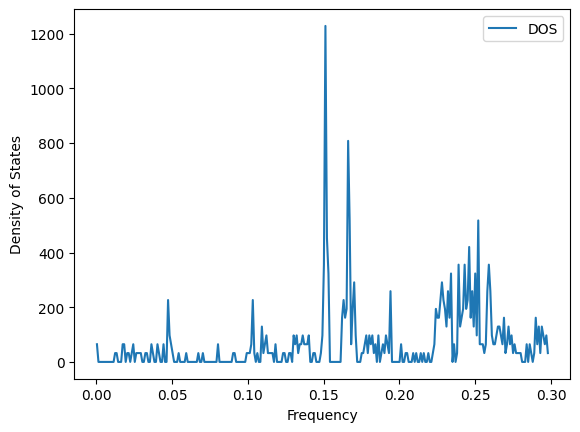

In [ ]:
# gme.freqs is shape (n_kpoints, n_bands)
freqs = gme.freqs
#plot
# Flatten to 1D array (all frequencies across k-points and bands)
all_freqs = freqs.flatten()

# Define frequency bins
num_bins = 300
freq_min, freq_max = all_freqs.min(), all_freqs.max()
bins = np.linspace(freq_min, freq_max, num_bins)

# Histogram → counts per bin
dos, bin_edges = np.histogram(all_freqs, bins=bins, density=False)

# Convert to DOS (states per unit frequency per k-point)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
dos = dos / (len(freqs) * (bin_edges[1] - bin_edges[0]))

# Plot DOS
plt.plot(bin_centers, dos, label="DOS")
plt.xlabel("Frequency")
plt.ylabel("Density of States")
plt.legend()
plt.show()


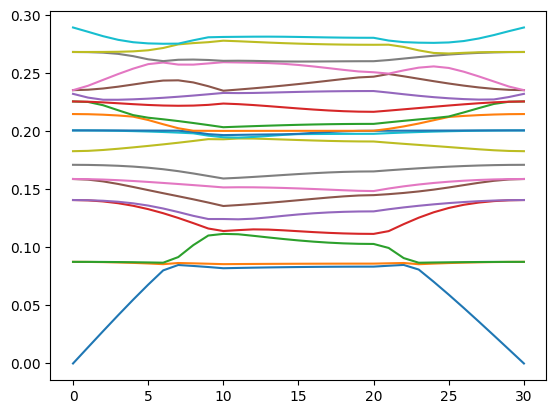

In [10]:
plt.plot(gme.freqs)